#0. Overview

Practical notebook for COVID-19 population incidence forecasting using LSTM network and data from FlowMaps services.


In [17]:
!nvidia-smi

Thu Feb 11 10:26:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#1. Data collection

Load libraries

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
import os
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [80]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Helpers:

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [23]:
today = datetime.today().strftime('%Y-%m-%d')
print(today)

2021-02-11


In [22]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


Flowmaps

In [25]:
#https://flowmaps.life.bsc.es/flowboard/static/js/mobility.js
province_id_to_name = {'17': 'Girona', '43': 'Tarragona','08': 'Barcelona', '25': 'Lleida'}

In [26]:
#FLOW-Maps end-points
URL_IN_CCAA = "https://flowmaps.life.bsc.es/api/total_incoming_daily_mobility"
URL_OUT_CCAA = "https://flowmaps.life.bsc.es/api/total_outgoing_daily_mobility" 

INCID_CAT = "https://flowmaps.life.bsc.es/api/incidence"   
URL_RISK_CCAA = "https://flowmaps.life.bsc.es/api/incoming_risk_history/"

In [30]:
#Load incidence cases
payload = {"where":"{\"ev\":\"ES.covid_cpro\",\"start_date\":\"2020-01-01\",\"end_date\":\"" + today + "\"}"}
response = requests.get(INCID_CAT, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
print(response.url)

https://flowmaps.life.bsc.es/api/incidence?where=%7B%22ev%22%3A%22ES.covid_cpro%22%2C%22start_date%22%3A%222020-01-01%22%2C%22end_date%22%3A%222021-02-11%22%7D


In [31]:
#Filter for catalonia (into pandas)
dfCases = []
for i,row in enumerate(response.json()["_items"]):
    date = row.get("_id")
    
    dfDaily = pd.DataFrame(row.get("data"))

    dfRow = pd.DataFrame(np.array([date, 
     dfDaily.loc[dfDaily["id"]=="08"]["new_cases"].values[0], 
     dfDaily.loc[dfDaily["id"]=="17"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="43"]["new_cases"].values[0],
     dfDaily.loc[dfDaily["id"]=="25"]["new_cases"].values[0],
    ]).reshape(1,5), columns=["date","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"])
    dfCases.append(dfRow)

dfCases = pd.concat(dfCases)
print(len(dfCases))

#save
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

dfCases.to_csv("data_flow/cases_CAT_" + today + ".csv",index=False)

406


In [33]:
#Load income cases

dfInRisk=[]
for j,val in enumerate(province_id_to_name.keys()):
    payload = {"where":"{\"target\":\"" + val + "\",\"source_layer\":\"cnig_provincias\",\"target_layer\":\"cnig_provincias\",\"ev\":\"ES.covid_cpro\",\"total\":true}"}
    response = requests.get(URL_RISK_CCAA, params=payload, verify = 'flowmaps-life-bsc-es-chain.pem')
    print(response.url)
    df = pd.DataFrame(response.json()["_items"])
    print("CCAA:", val,df.shape)
    
    if len(dfInRisk) == 0:
        dfInRisk = df
        dfInRisk["inrisk_"+val] = dfInRisk["incoming_risk"]
        dfInRisk.date = pd.to_datetime(dfInRisk.date)
        dfInRisk = dfInRisk[["date","inrisk_"+val]]
    else:
        df["inrisk_"+val] = df["incoming_risk"]
        df.date = pd.to_datetime(df.date)
        df = df[["date","inrisk_"+val]]
        dfInRisk = pd.merge(dfInRisk,df,on="date",suffixes=('',''))#,left_index=False,right_index=False) 

#Save
dfInRisk.to_csv("data_flow/inrisk_CAT_"+ today +".csv",index=False)

https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2217%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 17 (359, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2243%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 43 (359, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2208%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CCAA: 08 (359, 2)
https://flowmaps.life.bsc.es/api/incoming_risk_history/?where=%7B%22target%22%3A%2225%22%2C%22source_layer%22%3A%22cnig_provincias%22%2C%22target_layer%22%3A%22cnig_provincias%22%2C%22ev%22%3A%22ES.covid_cpro%22%2C%22total%22%3Atrue%7D
CC

#2. Data preparation

In [ ]:
#today = "2021-01-26"

##2.1Mobility risk:

Load, merge, remove nulls and na imputation

(359, 5)
Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')
354   2021-02-03
355   2021-02-04
356   2021-02-05
357   2021-02-06
358   2021-02-07
Name: date, dtype: datetime64[ns]


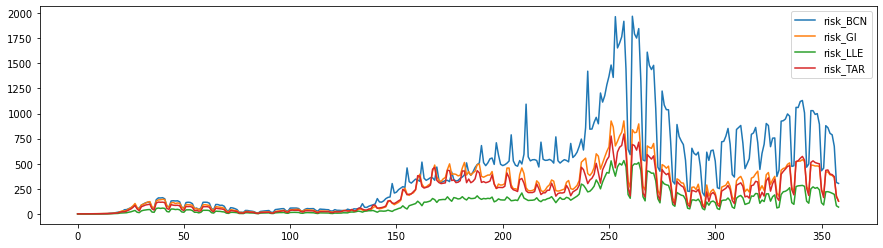

In [38]:
dfInRisk = pd.read_csv("data_flow/inrisk_CAT_" + today + ".csv")

for i,col in enumerate(dfInRisk.columns):
    if i==0:
        dfInRisk[col] = pd.to_datetime(dfInRisk[col])
    else:
        dfInRisk[col] = pd.to_numeric(dfInRisk[col])

dfInRisk.sort_values("date",ascending=True, inplace=True)
dfInRisk["risk_BCN"] = dfInRisk["inrisk_08"]
dfInRisk["risk_GI"] = dfInRisk["inrisk_17"]
dfInRisk["risk_TAR"] = dfInRisk["inrisk_43"]
dfInRisk["risk_LLE"] = dfInRisk["inrisk_25"]
dfInRisk = dfInRisk[["date","risk_BCN","risk_GI","risk_LLE","risk_TAR"]]

print(dfInRisk.shape)
print(dfInRisk.columns)
print(dfInRisk["date"].iloc[-5:])

#Plot
dfInRisk.iloc[:,1:].plot(figsize=(15,4))
plt.show()

Index(['date', 'risk_BCN', 'risk_GI', 'risk_LLE', 'risk_TAR'], dtype='object')


,date,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
0,2020-02-15,0.074989,0.173172,0.057394,0.116537
1,2020-02-16,0.149325,0.313411,0.100352,0.206053
2,2020-02-17,0.218067,0.434314,0.147659,0.295824
3,2020-02-18,0.291786,0.561055,0.196633,0.390014
4,2020-02-19,0.369210,0.685204,0.246724,0.486692


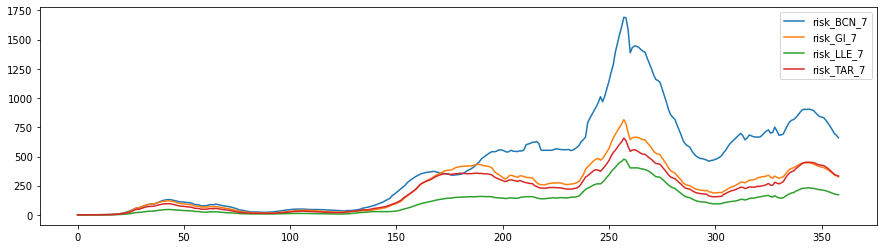

In [39]:
# Flattening daily oscil.lations: daily mean of the last 7 days

cols = dfInRisk.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInRisk.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInRisk.iloc[i-j,k]
        zn.append(acc/7)

    dfInRisk[cols[k] + "_7"] = zn
    
dfInRisk = dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]]
display(dfInRisk.head())

dfInRisk.iloc[:,1:].plot(figsize=(15,4))
plt.show()

##2.2 Incidence:

Load, merge, remove nulls and na imputation

(406, 7) Index(['date', 'new_cases', 'new_cases_BCN', 'new_cases_GI', 'new_cases_TAR',
       'new_cases_LLE', 'total_cases'],
      dtype='object')


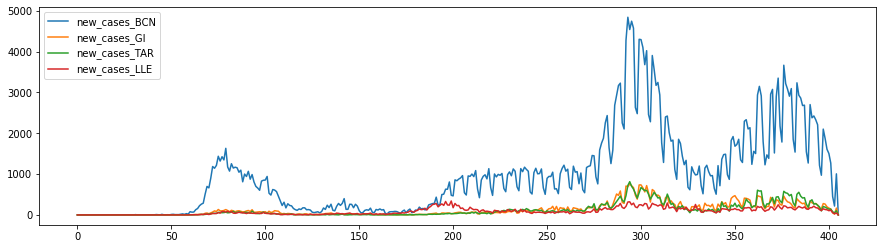

In [40]:
dfCases = pd.read_csv("data_flow/cases_CAT_" + today + ".csv")
dfCases["date"] = pd.to_datetime(dfCases["date"])
dfCases.sort_values("date",ascending=True, inplace=True)

#Aggregate
dfCases["new_cases"] = np.nansum(dfCases[['new_cases_BCN', 'new_cases_GI', 'new_cases_TAR']],axis=1)
dfCases = dfCases[["date","new_cases","new_cases_BCN","new_cases_GI","new_cases_TAR","new_cases_LLE"]]
dfCases["total_cases"] = np.cumsum(dfCases["new_cases"].values)
print(dfCases.shape,dfCases.columns)

dfCases.iloc[:,2:-1].plot(figsize=(15,4))
plt.show()

,date,new_cases,new_cases_BCN,new_cases_GI,new_cases_TAR,new_cases_LLE,total_cases,new_cases_7,new_cases_BCN_7,new_cases_GI_7,new_cases_TAR_7,new_cases_LLE_7,total_cases_7
0,2020-01-01,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
1,2020-01-02,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2020-01-03,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.142857,0.0
3,2020-01-04,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.142857,0.0
4,2020-01-05,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.142857,0.0


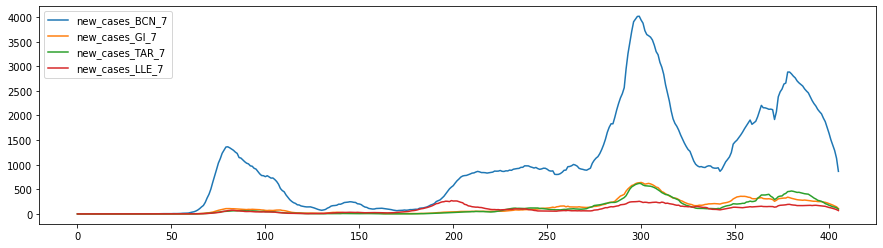

In [41]:
# Flattening daily oscil.lations: daily mean of the last 7 days

cols = dfCases.columns
for k in range(1,len(cols)):
    zn = []
    for i in range(dfCases.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfCases.iloc[i-j,k]
        zn.append(acc/7)

    dfCases[cols[k] + "_7"] = zn

display(dfCases.head())

dfCases[["new_cases_BCN_7","new_cases_GI_7","new_cases_TAR_7","new_cases_LLE_7"]].plot(figsize=(15,4))
plt.show()

## 2.3 Merge data

In [42]:
#Merge data
dfAll = pd.merge(dfCases[["date","new_cases","total_cases","new_cases_7",
                         "new_cases_GI_7","new_cases_LLE_7","new_cases_BCN_7","new_cases_TAR_7"]],
                 dfInRisk[["date","risk_BCN_7","risk_GI_7","risk_LLE_7","risk_TAR_7"]], 
                 how="left",on="date")
dfAll["date"] = pd.to_datetime(dfAll["date"])

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.tail()

(406, 12)
date                0
new_cases           0
total_cases         0
new_cases_7         0
new_cases_GI_7      0
new_cases_LLE_7     0
new_cases_BCN_7     0
new_cases_TAR_7     0
risk_BCN_7         47
risk_GI_7          47
risk_LLE_7         47
risk_TAR_7         47
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
401,2021-02-05,1556,490831,1863.142857,194.857143,123.142857,1505.857143,162.428571,698.397975,343.802178,179.879967,347.623960
402,2021-02-06,582,491413,1721.714286,179.857143,112.571429,1396.428571,145.428571,681.754401,335.604898,175.708233,338.305665
403,2021-02-07,286,491699,1588.142857,161.000000,101.428571,1288.571429,138.571429,660.050209,325.666836,172.690924,333.252417
404,2021-02-08,1274,492973,1400.714286,145.142857,86.857143,1132.000000,123.571429,NaN,NaN,NaN,NaN
405,2021-02-09,1,492974,1068.571429,107.285714,68.000000,864.857143,96.428571,NaN,NaN,NaN,NaN


In [43]:
#Remove days without mobility index 
dfAll = dfAll.iloc[46:]

#Remove last 3 days 
dfAll = dfAll.iloc[:-3]

print(dfAll.shape)
print(dfAll.isnull().sum())
dfAll.tail()

(357, 12)
date               0
new_cases          0
total_cases        0
new_cases_7        0
new_cases_GI_7     0
new_cases_LLE_7    0
new_cases_BCN_7    0
new_cases_TAR_7    0
risk_BCN_7         0
risk_GI_7          0
risk_LLE_7         0
risk_TAR_7         0
dtype: int64


,date,new_cases,total_cases,new_cases_7,new_cases_GI_7,new_cases_LLE_7,new_cases_BCN_7,new_cases_TAR_7,risk_BCN_7,risk_GI_7,risk_LLE_7,risk_TAR_7
398,2021-02-02,2326,485494,2320.285714,235.571429,154.142857,1875.000000,209.714286,786.827285,385.844251,200.201118,398.317776
399,2021-02-03,1968,487462,2178.142857,224.714286,141.428571,1758.285714,195.142857,759.872927,373.298755,194.496158,381.924517
400,2021-02-04,1813,489275,2024.714286,208.714286,130.714286,1640.142857,175.857143,729.723980,359.775603,186.291398,365.861132
401,2021-02-05,1556,490831,1863.142857,194.857143,123.142857,1505.857143,162.428571,698.397975,343.802178,179.879967,347.623960
402,2021-02-06,582,491413,1721.714286,179.857143,112.571429,1396.428571,145.428571,681.754401,335.604898,175.708233,338.305665


## 2.4 Data for supervised learning format 
[rows,timepoints,features]

(316, 420)
Index(['var1(t-21)', 'var2(t-21)', 'var3(t-21)', 'var4(t-21)', 'var5(t-21)',
       'var6(t-21)', 'var7(t-21)', 'var8(t-21)', 'var9(t-21)', 'var10(t-21)',
       ...
       'var1(t+20)', 'var2(t+20)', 'var3(t+20)', 'var4(t+20)', 'var5(t+20)',
       'var6(t+20)', 'var7(t+20)', 'var8(t+20)', 'var9(t+20)', 'var10(t+20)'],
      dtype='object', length=420)


,var1(t-21),var2(t-21),var3(t-21),var4(t-21),var5(t-21),var6(t-21),var7(t-21),var8(t-21),var9(t-21),var10(t-21)
21,3.0,5.428571,0.0,0.0,5.428571,0.142857,0.149325,0.313411,0.100352,0.206053
22,1.0,5.142857,0.0,0.0,5.142857,0.142857,0.218067,0.434314,0.147659,0.295824
23,5.0,5.428571,0.0,0.0,5.428571,0.142857,0.291786,0.561055,0.196633,0.390014
24,1.0,4.285714,0.0,0.0,4.285714,0.142857,0.369210,0.685204,0.246724,0.486692
25,11.0,5.142857,0.0,0.0,5.142857,0.000000,0.458660,0.854488,0.297012,0.608057



Data for testing: 295 



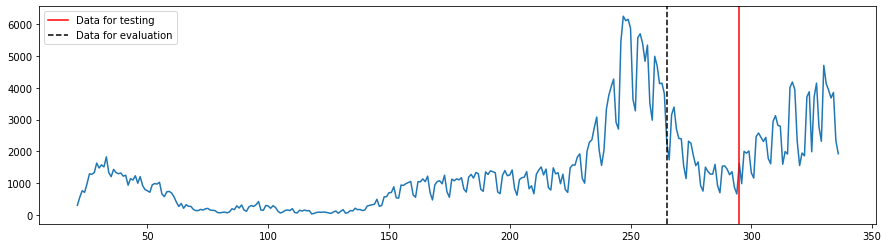

In [47]:
cols = [
         'new_cases',
         'new_cases_7',
         'new_cases_GI_7',
         'new_cases_TAR_7',
         'new_cases_BCN_7',
         'new_cases_LLE_7',    
         'risk_BCN_7',
         'risk_GI_7',
         'risk_LLE_7',
         'risk_TAR_7'
]
res = series_to_supervised(dfAll.loc[:,cols].values,21,21)
print(res.shape)
print(res.columns)

#data
display(res.iloc[:,:10].head())

# Unseen test data
THR = res.shape[0]-21
print("\nData for testing:",THR,"\n")

#Plot
plt.figure(figsize=(15,4))
plt.plot(res["var1(t)"])
plt.axvline(THR,c="r",label="Data for testing")
plt.axvline(int(THR-(THR*0.10)),c="black", ls="--", label="Data for evaluation")
plt.legend()
plt.show()


In [48]:
#Patition train/test
train_X = res.iloc[:THR,:210].values.reshape(-1,21,10)
train_y = res.iloc[:THR,[210+(10*i) for i in range(21)]].values.reshape(-1,21)
test_X = res.iloc[THR:,:210].values.reshape(-1,21,10)
test_y = res.iloc[THR:,[210+(10*i) for i in range(21)]].values.reshape(-1,21)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(295, 21, 10) (295, 21) (21, 21, 10) (21, 21)


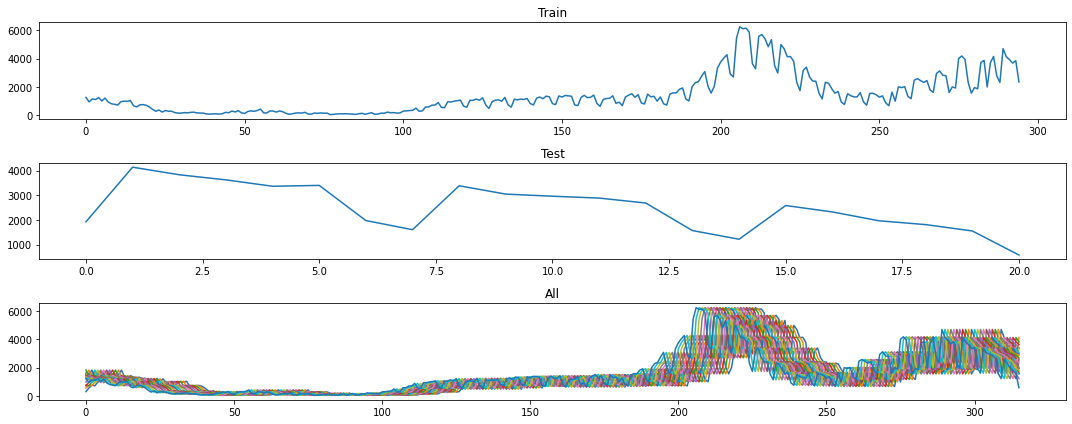

In [51]:
plt.figure(figsize=(15,6))
ax=plt.subplot(2,1,1)
ax.plot(range(len(train_y)),train_y[:,-1])
ax.set_title("Train")
ax=plt.subplot(2,1,2)
ax.plot(range(len(test_y)),test_y[:,-1])
ax.set_title("Test")
plt.tight_layout()
plt.show()

In [52]:
# normalize features
scalers_X = []
for i in range(train_X.shape[-1]):

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
    test_X[:,:,i] = scaler.transform(test_X[:,:,i])
    scalers_X.append(scaler)
    
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y.reshape(-1,21))
test_y = scaler_y.transform(test_y.reshape(-1,21))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(295, 21, 10) (295, 21) (21, 21, 10) (21, 21)


#3. Modeling

In [53]:
fname = "best_model_CAT"

In [61]:
bs=8
ITS = 1
dropout=0.1
numCells=100
epochs=500
patience=10

In [62]:
# fit network
history=[]
min_tr = []
min_val = []

#Iterate to learn several networks
for i in range(ITS):

    #Build model
    model = keras.Sequential()
    model.add(keras.layers.LSTM(numCells, activation="relu",
                                input_shape=(train_X.shape[1], train_X.shape[2]),recurrent_dropout=dropout))
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(21))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=["mae"])
    
    #Add callbacks
    es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                       verbose=1, patience=patience)
    mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                         monitor='val_mae', 
                                         verbose=1, save_best_only=True)

    history.append(model.fit(train_X, train_y, epochs=epochs, batch_size=bs, 
                        callbacks=[es,mc],
                        validation_split=0.10, verbose=0, shuffle=False))
    
    ix = np.argmin(history[-1].history.get('val_mae'))
    min_val.append(history[-1].history.get('val_mae')[ix])
    min_tr.append(history[-1].history.get('mae')[ix])

print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
print("MIN VAL:",np.mean(min_val),np.std(min_val))


Epoch 00001: val_mae improved from inf to 0.20009, saving model to models/best_model_CAT_0.h5

Epoch 00002: val_mae did not improve from 0.20009

Epoch 00003: val_mae did not improve from 0.20009

Epoch 00004: val_mae improved from 0.20009 to 0.19549, saving model to models/best_model_CAT_0.h5

Epoch 00005: val_mae improved from 0.19549 to 0.18492, saving model to models/best_model_CAT_0.h5

Epoch 00006: val_mae improved from 0.18492 to 0.17552, saving model to models/best_model_CAT_0.h5

Epoch 00007: val_mae improved from 0.17552 to 0.17061, saving model to models/best_model_CAT_0.h5

Epoch 00008: val_mae did not improve from 0.17061

Epoch 00009: val_mae improved from 0.17061 to 0.16452, saving model to models/best_model_CAT_0.h5

Epoch 00010: val_mae improved from 0.16452 to 0.15348, saving model to models/best_model_CAT_0.h5

Epoch 00011: val_mae did not improve from 0.15348

Epoch 00012: val_mae improved from 0.15348 to 0.13826, saving model to models/best_model_CAT_0.h5

Epoch 0

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
MAE VALSET: 0 0.10732904821634293
MAE VALSE (MEAN): 0.10732904821634293


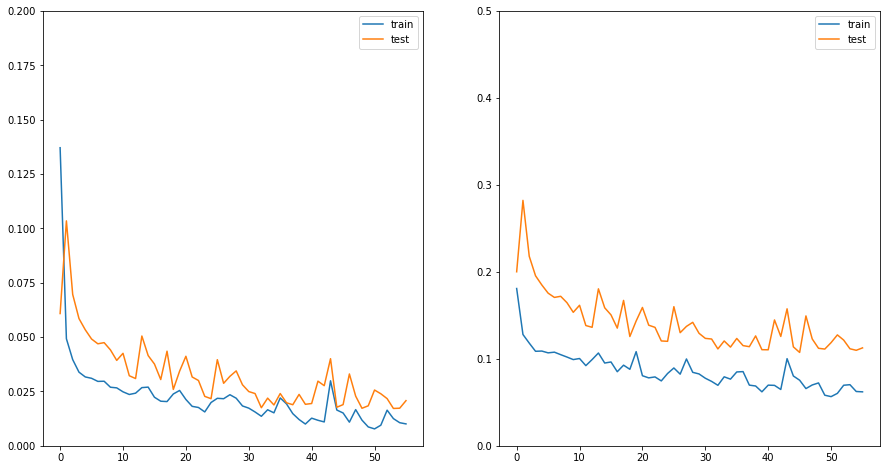

In [72]:
# plot history
plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)

print(history[0].history.keys())

mins = []
for i in range(len(history)):
    mins.append(np.min(history[i].history.get('val_mae')))
    print("MAE VALSET:", i,np.min(history[i].history.get('val_mae')))
    ax.plot(history[i].history['loss'], label='train')
    ax.plot(history[i].history['val_loss'], label='test')
    ax.set_ylim(0,0.2)
    ax.legend()
print("MAE VALSE (MEAN):", np.mean(mins))

ax = plt.subplot(1,2,2)
for i in range(len(history)):
    ax.plot(history[i].history['mae'], label='train')
    ax.plot(history[i].history['val_mae'], label='test')
    ax.set_ylim(0,0.5)
    ax.legend()
plt.show()


#3. Evaluation
Load model

In [73]:
print("Loading...", fname)
model = tf.keras.models.load_model("models/"+ fname + "_" + str(0) +'.h5')

Loading... best_model_CAT


(295, 21)
(295, 21)


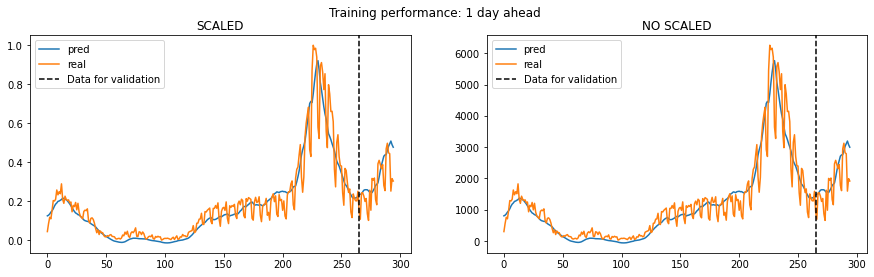

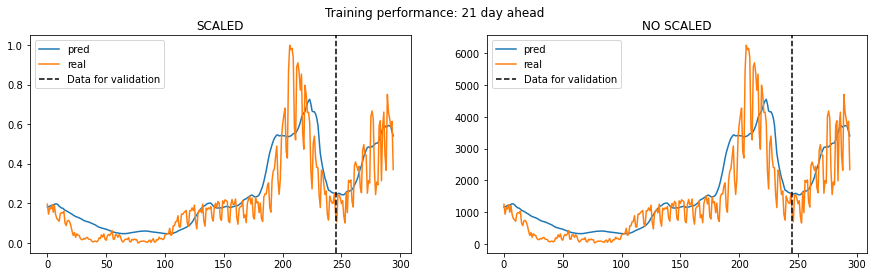

In [76]:
#Inference:Train & validation data

tr = model.predict(train_X)
print(tr.shape)
tr_y_pred = scaler_y.inverse_transform(tr)
tr_y_real = scaler_y.inverse_transform(train_y)
print(tr_y_real.shape)

for i in [0,20]:
    fig = plt.figure(figsize=(15,4))
    ax = plt.subplot(1,2,1)
    ax.plot(range(len(tr)),tr[:,i], label="pred")
    ax.plot(range(len(tr)),train_y[:,i],label="real")
    ax.set_title("SCALED")
    ax.axvline(int(THR-(THR*0.1)-i),c="black",ls="--",label="Data for validation")
    ax.legend()
    ax = plt.subplot(1,2,2)
    ax.plot(range(len(tr)),tr_y_pred[:,i], label="pred")
    ax.plot(range(len(tr)),tr_y_real[:,i],label="real")
    ax.set_title("NO SCALED")
    ax.axvline(int(THR-(THR*0.1)-i),c="black",ls="--",label="Data for validation")
    ax.legend()
    plt.suptitle("Training performance: {} day ahead".format(i+1))
    plt.show()

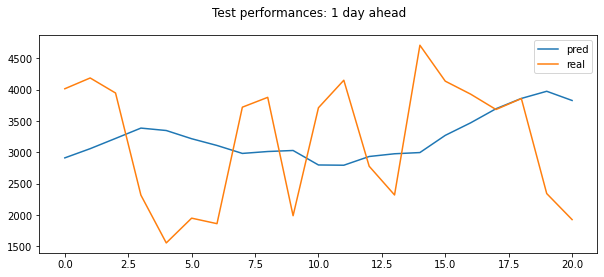

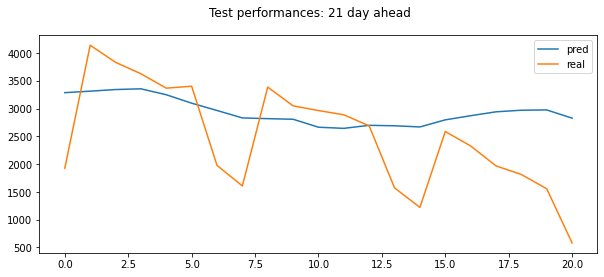

In [77]:
#Inference:Test data

ts = model.predict(test_X)
ts_y_pred = scaler_y.inverse_transform(ts)
ts_y_real = scaler_y.inverse_transform(test_y)

for i in [0,20]:
    plt.figure(figsize=(10,4))
    ax = plt.subplot(1,1,1)
    ax.plot(range(len(ts_y_pred)),ts_y_pred[:,i], label="pred")
    ax.plot(range(len(ts_y_real)),ts_y_real[:,i],label="real")
    plt.suptitle("Test performances: {} day ahead".format(i+1))
    plt.legend()
    plt.show()

In [78]:
#Test evauation: MAE

print("Tr/Ts shapes:", tr_y_pred.shape, ts_y_pred.shape)

maes = []
for i in range(21):
    maes.append(metrics.mean_absolute_error(ts_y_real[:,i], ts_y_pred[:,i]))
    print("Forecast:", i, "day")
    print('Test mean absolute error (mae): {}'.format(maes[-1]))
    if i == 20:
        print('Test r^2: {}'.format(metrics.r2_score(ts_y_real[:,i], ts_y_pred[:,i])))

(295, 21) (21, 21)
Forecast: 0 day
Test mean absolute error (mae): 982.5352143787202
Forecast: 1 day
Test mean absolute error (mae): 1000.3751511346726
Forecast: 2 day
Test mean absolute error (mae): 911.1526808965774
Forecast: 3 day
Test mean absolute error (mae): 919.7528250558036
Forecast: 4 day
Test mean absolute error (mae): 879.5206008184524
Forecast: 5 day
Test mean absolute error (mae): 789.8704892113095
Forecast: 6 day
Test mean absolute error (mae): 823.1824776785714
Forecast: 7 day
Test mean absolute error (mae): 890.3972865513393
Forecast: 8 day
Test mean absolute error (mae): 875.8666178385416
Forecast: 9 day
Test mean absolute error (mae): 848.6747581845239
Forecast: 10 day
Test mean absolute error (mae): 836.747802734375
Forecast: 11 day
Test mean absolute error (mae): 799.9726213727679
Forecast: 12 day
Test mean absolute error (mae): 746.6544596354166
Forecast: 13 day
Test mean absolute error (mae): 758.5460611979166
Forecast: 14 day
Test mean absolute error (mae): 841.

In [79]:
print("Daily mean absolute error (mae) of infected cases :", np.mean(maes))

Daily mean absolute error (mae) of infected cases : 835.063098449015


In [ ]:
#Cumulative


Cumulative prediction at: 0 day ahead
Incremento de casos en el período: 62942.0
Incremento predicho en el período: 64960.8125
Diferencia de casos entre real y modelo en el período: -2018.8125
Risk ratio pred vs real: 1.0320741714594388
Risk ratio real vs pred: 0.9689226100735732

Cumulative prediction at: 1 day ahead
Incremento de casos en el período: 62894.0
Incremento predicho en el período: 63804.5625
Diferencia de casos entre real y modelo en el período: -910.5625
Risk ratio pred vs real: 1.0144777323751073
Risk ratio real vs pred: 0.9857288810655194

Cumulative prediction at: 2 day ahead
Incremento de casos en el período: 62779.0
Incremento predicho en el período: 71764.78125
Diferencia de casos entre real y modelo en el período: -8985.78125
Risk ratio pred vs real: 1.1431335518246548
Risk ratio real vs pred: 0.8747884255551883

Cumulative prediction at: 3 day ahead
Incremento de casos en el período: 64087.0
Incremento predicho en el período: 70637.9375
Diferencia de casos entre

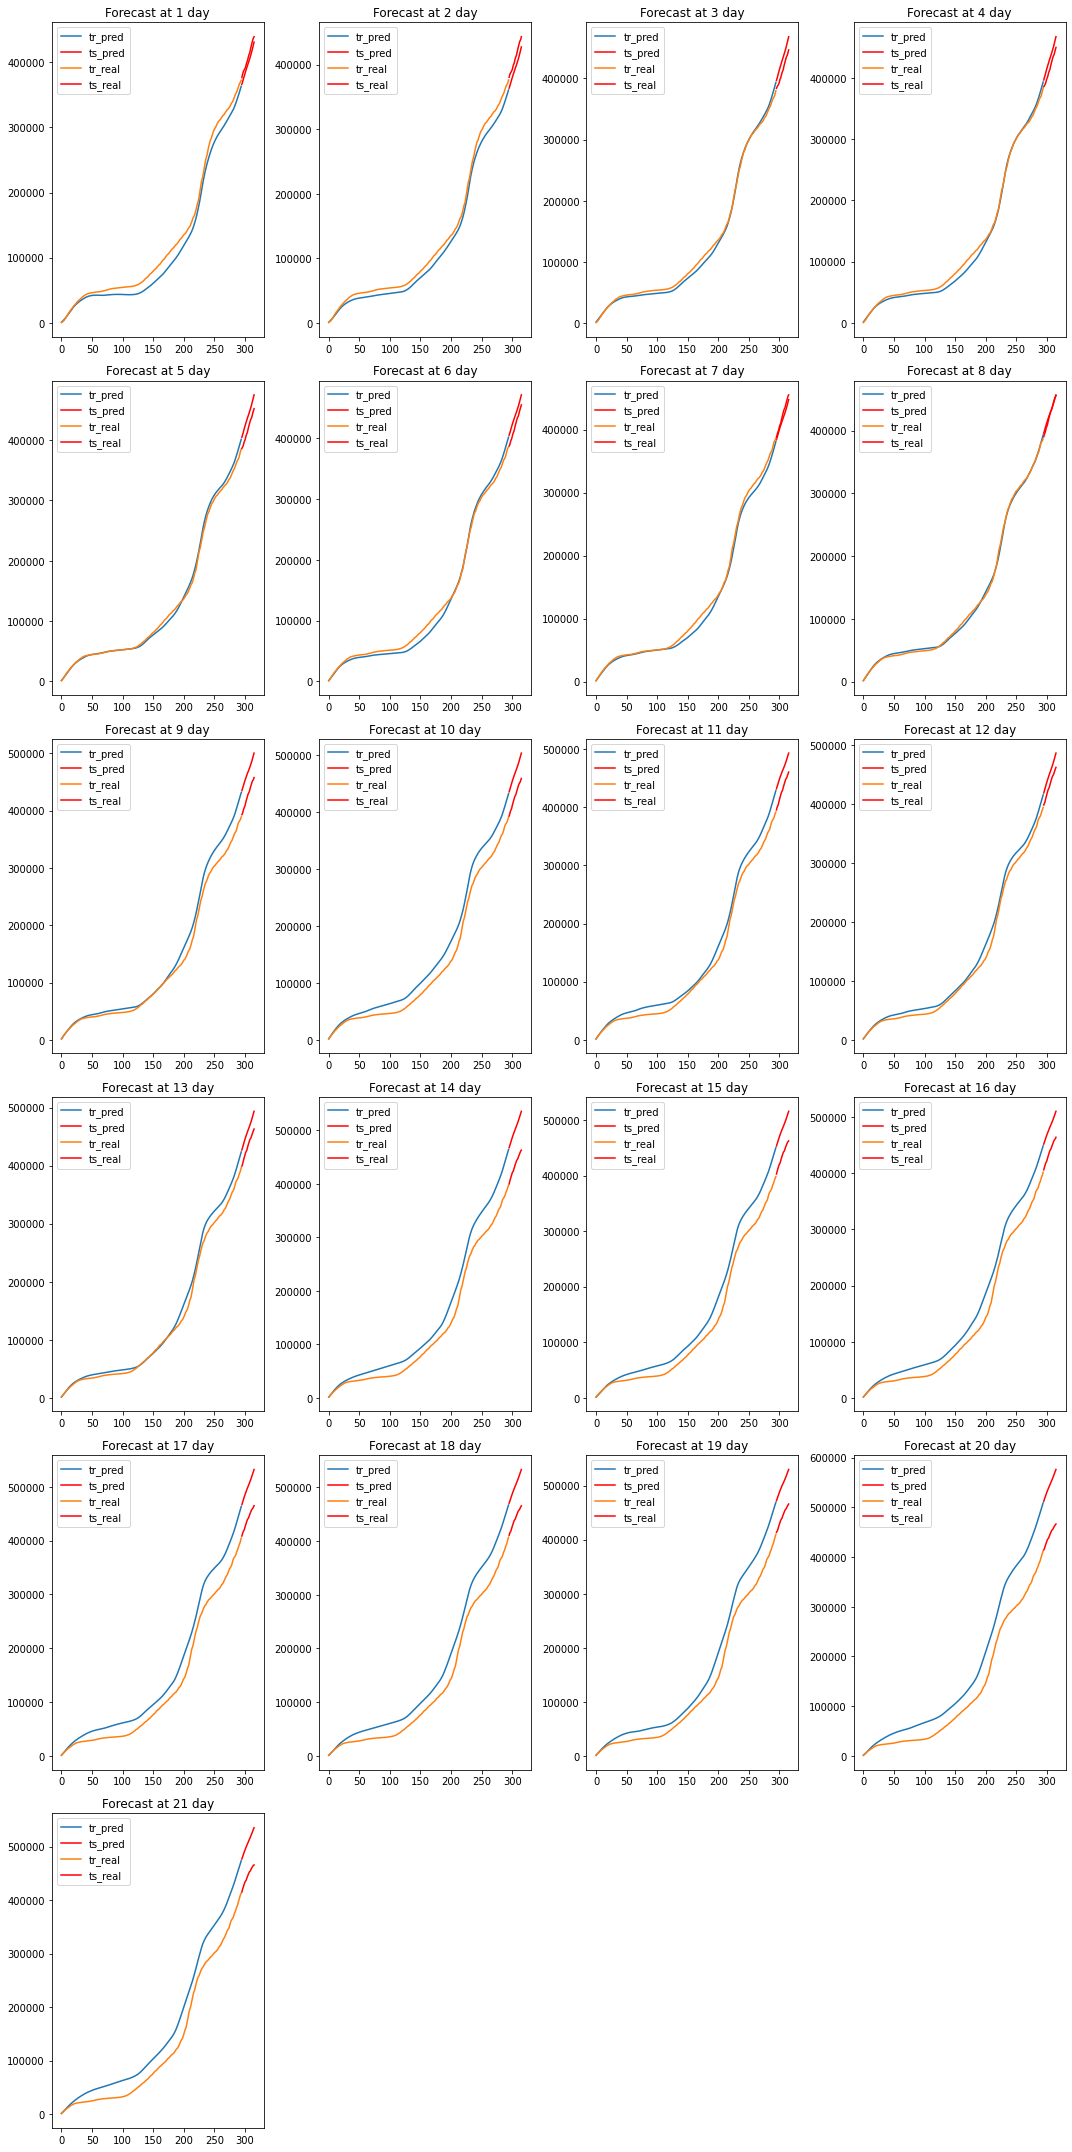

In [81]:
err_diffs = []
err_prs = []
err_rps = []

plt.figure(figsize=(15,30))
for i in range(21):
    
    y_pred = np.concatenate([tr_y_pred[:,i], ts_y_pred[:,i]])
    y_cum_pred = np.cumsum(y_pred)

    y_real = np.concatenate([tr_y_real[:,i], ts_y_real[:,i]])
    y_cum_real = np.cumsum(y_real)
    

    contador_pred = y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]
    err_diff = y_cum_real[-1] - y_cum_real[len(tr_y_pred)]- contador_pred
    
    print("\nCumulative prediction at:", i, "day ahead")
    print("Incremento de casos en el período: {}".format(y_cum_real[-1] - y_cum_real[len(tr_y_pred)]))
    print("Incremento predicho en el período: {}".format(y_cum_pred[-1] - y_cum_pred[len(tr_y_pred)]))
    print("Diferencia de casos entre real y modelo en el período: {}".format(err_diff))  
    
    err_pr = contador_pred / (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])
    err_rp = (y_cum_real[-1] - y_cum_real[len(tr_y_pred)])/contador_pred
    print("Risk ratio pred vs real:", err_pr)
    print("Risk ratio real vs pred:", err_rp)
    
    err_diffs.append(err_diff)
    err_prs.append(err_pr)
    err_rps.append(err_rp)
    
    ax = plt.subplot(6,4,i+1)
    ax.plot(range(len(tr_y_pred)), y_cum_pred[:len(tr_y_pred)],label="tr_pred")
    ax.plot(range(len(tr_y_pred),len(tr_y_pred)+len(ts_y_pred)), y_cum_pred[len(tr_y_pred):], c="red",label="ts_pred")
    ax.plot(range(len(tr_y_real)), y_cum_real[:len(tr_y_pred)],label="tr_real")
    ax.plot(range(len(tr_y_real),len(tr_y_real)+len(ts_y_real)), y_cum_real[len(tr_y_pred):], c="red",label="ts_real")
    ax.set_title("Forecast at "+str(i+1)+ " day")
    ax.legend()

plt.tight_layout()
plt.show()

In [82]:
print("Daily cumulative diff error (in 21 days period):", np.mean(err_diffs),"+/-",np.std(err_diffs))
print("Daily cumulative pred/real ratio error (in 21 days period):", np.mean(err_prs),"+/-",np.std(err_prs))

Daily cumulative diff error (in 21 days period): -3322.15625 +/- 4379.873700002797
Daily cumulative pred/real ratio error (in 21 days period): 1.0588759573242639 +/- 0.07700634370270708


#3. Forecasting
Insight into the short-time expected evolution of the incidence 

In [83]:
res_test = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)
print(cols)
res_test.shape

['new_cases', 'new_cases_7', 'new_cases_GI_7', 'new_cases_TAR_7', 'new_cases_BCN_7', 'new_cases_LLE_7', 'risk_BCN_7', 'risk_GI_7', 'risk_LLE_7', 'risk_TAR_7']


(357, 420)

In [84]:
#Find rows for future pred
ftest_X = res_test.iloc[-1,:210].values.reshape(-1,21,10)
ftest_y = res_test.iloc[-1,[210+(10*i) for i in range(21)]].values.reshape(-1,21)
print(ftest_X.shape, ftest_y.shape)
print(ftest_y[0,:])

(1, 21, 10) (1, 21)
[582.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan]


In [85]:
# normalize features
for i in range(ftest_X.shape[-1]):

    # normalize features
    ftest_X[:,:,i] = scalers_X[i].transform(ftest_X[:,:,i])

print(ftest_X.shape)
print(np.max(ftest_X),np.min(ftest_X),np.mean(ftest_X),np.std(ftest_X))

(1, 21, 10)
0.7383908045977011 0.19083601286173632 0.5135714984964451 0.1122035889404881


In [86]:
#Forecasting last X days for all models
all_preds = []
for i in range(ITS):

    #Load
    print("\nLoading model:", i)
    model = tf.keras.models.load_model("models/"+ fname + "_" + str(i) +'.h5')

    #Predict
    preds = model.predict(ftest_X)

    #Inverse scaling
    preds_inv = scaler_y.inverse_transform(preds)
    print(len(preds_inv), np.max(preds_inv), np.min(preds_inv))
    print(preds_inv.shape)
    all_preds.append(preds_inv)


Loading model: 0
1 2309.8108 1522.6407
(1, 21)


In [87]:
all_preds_aux = np.stack((all_preds))
print(all_preds_aux.shape)

all_preds_aux[:,-1,:].mean(axis=0)
all_preds_aux[:,-1,:].std(axis=0)

(1, 1, 21)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [88]:
all_res = all_preds_aux[:,:all_preds_aux.shape[1]]
for i in range(all_preds_aux.shape[1]-1,19,-1):
    all_res = np.hstack((all_preds_aux[:,i,-1].reshape(10,1),all_res))
    #print(all_res.shape)

all_res = np.array(all_res)
print(all_res.shape)

(1, 1, 21)


In [90]:
dfPreds = pd.DataFrame(np.hstack((all_res)).astype(int).reshape(ITS,21),
                       columns=["d"+str(i) for i in range(21)])
dfPreds.astype(int).to_csv("preds_infected_21days" + today + ".csv",index=False)
dfPreds.describe().T

,count,mean,std,min,25%,50%,75%,max
d0,1.0,1806.0,NaN,1806.0,1806.0,1806.0,1806.0,1806.0
d1,1.0,1680.0,NaN,1680.0,1680.0,1680.0,1680.0,1680.0
d2,1.0,1869.0,NaN,1869.0,1869.0,1869.0,1869.0,1869.0
d3,1.0,1836.0,NaN,1836.0,1836.0,1836.0,1836.0,1836.0
d4,1.0,1762.0,NaN,1762.0,1762.0,1762.0,1762.0,1762.0
d5,1.0,1820.0,NaN,1820.0,1820.0,1820.0,1820.0,1820.0
d6,1.0,1522.0,NaN,1522.0,1522.0,1522.0,1522.0,1522.0
d7,1.0,1597.0,NaN,1597.0,1597.0,1597.0,1597.0,1597.0
d8,1.0,1908.0,NaN,1908.0,1908.0,1908.0,1908.0,1908.0
d9,1.0,1705.0,NaN,1705.0,1705.0,1705.0,1705.0,1705.0


In [91]:
import datetime
import matplotlib.dates as mdates
date_time_str = today #'2021-01-30' #Last data collected day
base = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
date_list = [base + datetime.timedelta(days=x) for x in range(21)]

In [92]:
dfPredsT = dfPreds.T
dfPredsT.reset_index(drop=True, inplace=True)
dfPredsT["date"] = date_list
dfPredsT.head()

,0,date
0,1806,2021-02-11
1,1680,2021-02-12
2,1869,2021-02-13
3,1836,2021-02-14
4,1762,2021-02-15


In [94]:
print(dfPredsT[[i for i in range(ITS)]].mean(axis=1).mean(axis=0))
print(dfPredsT[[i for i in range(ITS)]].mean(axis=1).std(axis=0))
print(np.mean(dfPredsT[[i for i in range(ITS)]].values),
      np.std(dfPredsT[[i for i in range(ITS)]].values))

1886.5238095238096
203.99843603508805
1886.5238095238096 199.0820886080291


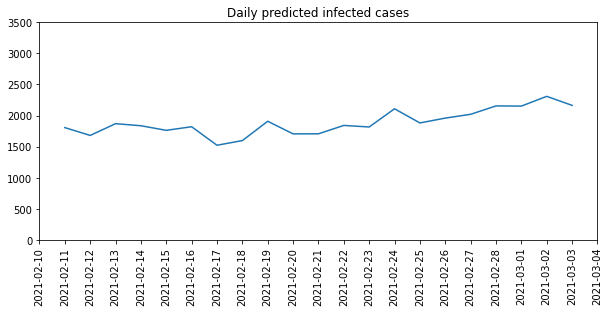

In [98]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.plot(dfPredsT["date"], dfPredsT[[i for i in range(ITS)]])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted infected cases")
plt.xticks(rotation='vertical')
plt.ylim(0,3500)
plt.show()


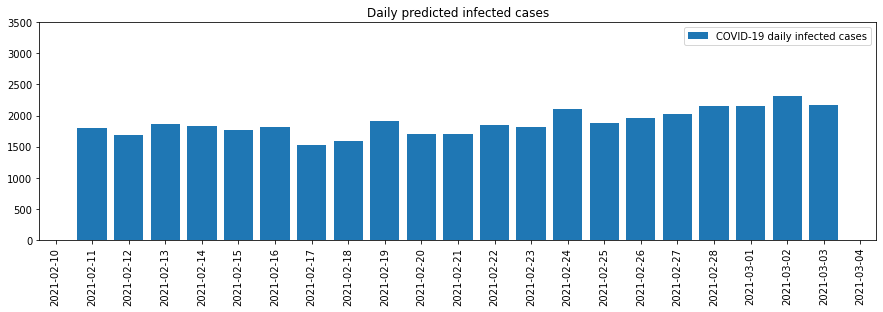

In [100]:
plt.figure(figsize=(15,4))
ax = plt.subplot(1,1,1)
ax.bar(dfPredsT["date"].values, np.mean(dfPredsT[[i for i in range(ITS)]], axis=1), 
            yerr=np.std(dfPredsT[[i for i in range(ITS)]], axis=1), label="COVID-19 daily infected cases")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted infected cases")
plt.xticks(rotation='vertical')
plt.ylim(0,3500)
plt.legend()
plt.show()

No handles with labels found to put in legend.


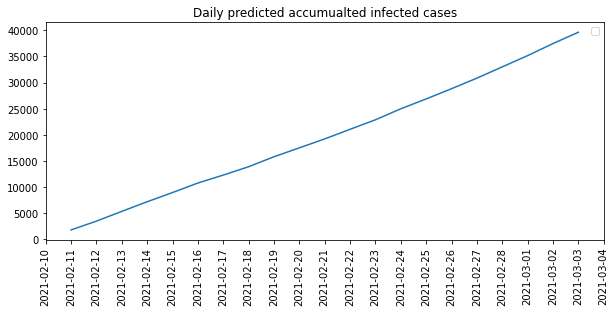

In [102]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1)
ax.errorbar(dfPredsT["date"], 
            dfPredsT[[i for i in range(ITS)]].cumsum().mean(axis=1),
            yerr=dfPredsT[[i for i in range(ITS)]].cumsum().std(axis=1))
ax.fill_between(dfPredsT["date"],
                dfPredsT[[i for i in range(ITS)]].cumsum().mean(axis=1)-dfPredsT[[i for i in range(ITS)]].cumsum().std(axis=1),
                dfPredsT[[i for i in range(ITS)]].cumsum().mean(axis=1)+dfPredsT[[i for i in range(ITS)]].cumsum().std(axis=1),
                alpha=0.2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.title("Daily predicted accumualted infected cases")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()